In [32]:
%pylab notebook

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/michael/.virtualenvs/tera/lib/python3.11/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['e']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [58]:
from svgpathtools import svg2paths, wsvg
from numpy import *
from fonts.font_helpers import print_table

In [3]:
paths, attributes = svg2paths('numbers.svg')
[a["id"] for a in attributes]

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'colon']

In [4]:
def getVecs(ps):
    a = set()
       
    for p in ps:
        a.add(p.start)
        a.add(p.end)
    a = array(list(a))
    
    lineInds = zeros((len(ps), 2), dtype=int)
    for i, p in enumerate(ps):
        lineInds[i, 0] = where(abs(a - p.start) == 0)[0][0]
        lineInds[i, 1] = where(abs(a - p.end) == 0)[0][0]
    
#     a -= ps[0].start
    a -= mean(a)
    return a, lineInds

getVecs(paths[0])

(array([-2.63669587-2.34105293j, -1.44251981-1.17746293j,
         2.63449829-2.34105293j,  1.44406039-1.17746293j,
        -1.44200081+1.25440007j, -2.63590087+2.26411578j,
         1.44406039+1.25440007j,  2.63449829+2.26411578j]),
 array([[1, 3],
        [3, 6],
        [6, 4],
        [4, 1],
        [0, 2],
        [2, 7],
        [7, 5],
        [5, 0]]))

In [5]:
def extrude(vs, ls, depth=3):
    n_vs = vs.shape[0]
    vs_ = zeros((n_vs * 2, 3), dtype=float)

    # bottom side at z = 0
    vs_[:n_vs, 0] = real(vs)
    vs_[:n_vs, 1] = imag(vs)
    vs_[:n_vs, 2] = -depth / 2

    # offset top side at z = depth
    vs_[n_vs:, :] = vs_[:vs.shape[0], :]
    vs_[n_vs:, 2] = depth / 2

    # add edges
    n_ls = ls.shape[0]
    ls_ = zeros((n_ls * 2 + n_vs, 2), dtype=int)
    # edges bottom side
    ls_[:n_ls, :] = ls
    # edges top side
    ls_[n_ls: n_ls * 2, :] = ls + n_vs
    # connect them
    ls_[n_ls * 2:, 0] = arange(n_vs)
    ls_[n_ls * 2:, 1] = arange(n_vs) + n_vs
    return vs_, ls_

In [52]:
verts = list()
edgs = list()
verts_end = list()
edgs_end = list()

for ps in paths:
    v, e = extrude(*getVecs(ps), depth=2)
    v[:, 1] *= -1  # mirror y-axis
    v = (v * 2**16).astype(int).flatten()
    
    verts.extend(v)
    verts_end.append(len(verts))
    
    edgs.extend(e.flatten())
    edgs_end.append(len(edgs))
    
#     lv = v.shape[0]
#     le = e.shape[0]
#     lvs.append(lv)
#     les.append(le)
#     edgs.append(e)

<IPython.core.display.Javascript object>


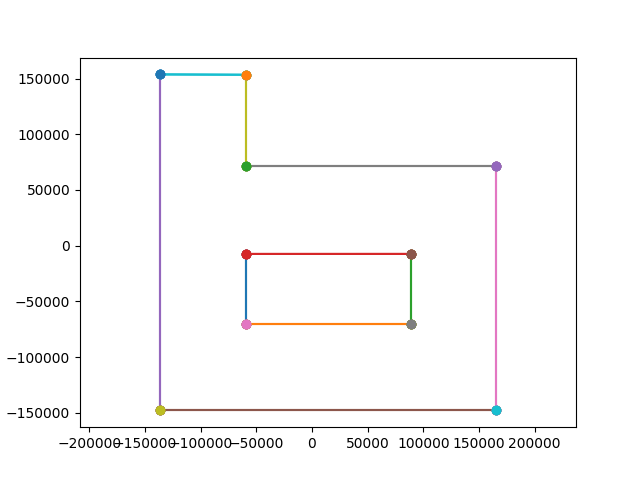

(-151867.65, 180654.65, -163025.75, 168882.75)

In [55]:
plot_id = 6

if plot_id > 0:
    vs = verts[verts_end[plot_id - 1]: verts_end[plot_id]]
else:
    vs = verts[0: verts_end[plot_id]]
vs = array(vs).reshape(-1, 3)

if plot_id > 0:
    es = edgs[edgs_end[plot_id - 1]: edgs_end[plot_id]]
else:
    es = edgs[0: edgs_end[plot_id]]
    
es = array(es).reshape(-1, 2)

close()
for e in es:
    v_a = vs[e[0], :]
    v_b = vs[e[1], :]
    plot([v_a[0], v_b[0]], [v_a[1], v_b[1]], '-o')
axis('equal')

# C code generation

In [94]:
def print_table2(vals, prefix='static const int all_vertices', **kwargs):
    print(f'{prefix}[{len(vals)}] = {{', file=kwargs.get("f"))
    print_table(vals, **kwargs)

In [102]:
with open('../src/fonts/wf_numbers.c', 'w') as f:
    print('''\
#include <stdint.h>
#include <stdio.h>
#include <wireframe_draw.h>

// -----------------------------------
//  3D objects: digits 0-9 and a colon
// -----------------------------------
    ''', file=f)
    print_table2(verts, prefix='static const int all_vertices', w=8, w_v=7, f=f)
    print_table2(edgs, prefix='static const uint16_t all_edges', w=8, w_v=7, f=f)
    print_table2(verts_end, prefix='static const uint16_t vertices_ends', w=8, w_v=7, f=f)
    print_table2(edgs_end, prefix='static const uint16_t edges_ends', w=8, w_v=7, f=f)

    print(f'''\
const edges_3d_t wf_numbers = {{
    .n_objects = {len(edgs_end)},
    .all_vertices = all_vertices,
    .all_edges = all_edges,
    .vertices_ends = vertices_ends,
    .edges_ends = edges_ends
}};
    ''', file=f)

print('wrote', f.name)

wrote ../src/fonts/wf_numbers.c


In [103]:
!cat ../src/fonts/wf_numbers.c

#include <stdint.h>
#include <stdio.h>
#include <wireframe_draw.h>

// -----------------------------------
//  3D objects: digits 0-9 and a colon
// -----------------------------------
    
static const int all_vertices[576] = {
-172798, 153423, -65536, -94536,  77166, -65536, 172654, 153423,
 -65536,  94637,  77166, -65536, -94502, -82208, -65536,-172746,
-148381, -65536,  94637, -82208, -65536, 172654,-148381, -65536,
-172798, 153423,  65536, -94536,  77166,  65536, 172654, 153423,
  65536,  94637,  77166,  65536, -94502, -82208,  65536,-172746,
-148381,  65536,  94637, -82208,  65536, 172654,-148381,  65536,
 -38481,-151088, -65536,  38775,-151088, -65536, -39068, 151088,
 -65536,  38775, 151088, -65536, -38481,-151088,  65536,  38775,
-151088,  65536, -39068, 151088,  65536,  38775, 151088,  65536,
-218451, 151229, -65536,-218733,  74749, -65536,  39898, 150704,
 -65536, -38306,  74749, -65536,  39898, -73518, -65536, -38306,
-152197, -65536, 217000, -73518, -65536, 217000,-152197,